In [14]:
import pandas as pd  
import matplotlib.pyplot as plt 
import numpy as np
from decimal import Decimal
from Utils import  *

CONSTANTS

In [15]:
DISTANCE_GALCHI_SUIRENITAR=30000
DISTANCE_BUDHI_SUIRENITAR=18500

MATPLLOTLIB SETTINGS

In [16]:
plt.style.use('ggplot')

Read CSV

In [17]:
galchi_df=pd.read_csv('Dataset/test/wl_galchi_test.csv')
budhi_df=pd.read_csv('Dataset/test/wl_khari_test.csv')
suirenitar_df=pd.read_csv('Dataset/test/wl_suirenitar_test.csv')


In [18]:
def preprocess_data(df):   
    df['datetime']=pd.to_datetime(df['datetime'])
    df['value']=pd.to_numeric(df['value'],errors='coerce')
    df.set_index('datetime',inplace=True)
    # df=handle_outliers(df)
    # handle_null_values(df)
    return df


In [19]:
    #Only the original df should be preprocessed,else there will be error
galchi_df=preprocess_data(galchi_df)
budhi_df=preprocess_data(budhi_df)
suirenitar_df=preprocess_data(suirenitar_df)      

C:\Users\aryan\AppData\Local\Temp\ipykernel_18660\1792643156.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['datetime']=pd.to_datetime(df['datetime'])
C:\Users\aryan\AppData\Local\Temp\ipykernel_18660\1792643156.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['datetime']=pd.to_datetime(df['datetime'])
C:\Users\aryan\AppData\Local\Temp\ipykernel_18660\1792643156.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['datetime']=pd.to_datetime(df['datetime'])


In [20]:
galchi_df['discharge']=galchi_df.apply(lambda row:calculate_discharge_galchi(row['value']),axis=1)
budhi_df['discharge']=budhi_df.apply(lambda row:calculate_discharge_budhi(row['value']),axis=1)
suirenitar_df['discharge']=suirenitar_df.apply(lambda row:calculate_discharge_suirenitar(row['value']),axis=1)


In [21]:
galchi_df['mean_velocity']=galchi_df.apply(lambda row:calculate_mean_velocity_galchi(row['discharge']),axis=1)
budhi_df['mean_velocity']=budhi_df.apply(lambda row:calculate_mean_velocity_buddhi(row['discharge']),axis=1)

In [22]:
galchi_df[['time_lag_hr', 'time_lag_min']] = galchi_df.apply(
    lambda row: pd.Series(calcualte_time(DISTANCE_GALCHI_SUIRENITAR, row['mean_velocity'])), axis=1
)
budhi_df[['time_lag_hr', 'time_lag_min']] = budhi_df.apply(
    lambda row: pd.Series(calcualte_time(DISTANCE_BUDHI_SUIRENITAR, row['mean_velocity'])), axis=1
)


SHIFT DF 

In [23]:

def create_shifted_df(df):
    shifted_data = [
    {'dateTime': (index + pd.DateOffset(hours=lag_hr,minutes=lag_min)), 'discharge': discharge}
    for index, lag_hr,lag_min, discharge in zip(df.index, df['time_lag_hr'],df['time_lag_min'], df['discharge'])
]
    return pd.DataFrame(shifted_data)

In [24]:
shifted_galchi_df=create_shifted_df(galchi_df)
shifted_budhi_df=create_shifted_df(budhi_df)


In [30]:
shifted_budhi_df
shifted_budhi_df['dateTime'] = pd.to_datetime(shifted_budhi_df['dateTime'])
shifted_budhi_df.set_index('dateTime',inplace=True)

shifted_galchi_df
shifted_galchi_df['dateTime'] = pd.to_datetime(shifted_galchi_df['dateTime'])
shifted_galchi_df.set_index('dateTime',inplace=True)

In [31]:

# Resample the data to a 5-minute frequency
shifted_budhi_df_resampled = shifted_budhi_df.resample('T').mean()

# Interpolate missing values
shifted_budhi_df_interpolated = shifted_budhi_df_resampled.interpolate(method='linear')


# Resample the data to a 5-minute frequency
shifted_galchi_df_resampled = shifted_galchi_df.resample('T').mean()

# Interpolate missing values
shifted_galchi_df_interpolated = shifted_galchi_df_resampled.interpolate(method='linear')

C:\Users\aryan\AppData\Local\Temp\ipykernel_18660\3654106487.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  shifted_budhi_df_resampled = shifted_budhi_df.resample('T').mean()
C:\Users\aryan\AppData\Local\Temp\ipykernel_18660\3654106487.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  shifted_galchi_df_resampled = shifted_galchi_df.resample('T').mean()


In [32]:
merged_df = pd.merge(
    shifted_galchi_df_interpolated, shifted_budhi_df_interpolated, 
    on='dateTime',      
    how='outer', 
    suffixes=('_galchi', '_budhi')
)

# Fill NaN with 0 and add the columns
merged_df['discharge'] = merged_df['discharge_galchi'].fillna(0) + merged_df['discharge_budhi'].fillna(0)


# Set 'discharge' to NaN if both columns are NaN
for index, row in merged_df.iterrows():
    if pd.isna(row['discharge_galchi']) and pd.isna(row['discharge_budhi']):
        merged_df.at[index, 'discharge'] = np.nan
        
        

In [33]:
merged_df

,discharge_galchi,discharge_budhi,discharge
dateTime,,,
2024-09-27 02:25:00,NaN,518.765045,518.765045
2024-09-27 02:26:00,NaN,517.353167,517.353167
2024-09-27 02:27:00,NaN,515.941289,515.941289
2024-09-27 02:28:00,NaN,514.529410,514.529410
2024-09-27 02:29:00,NaN,513.117532,513.117532
...,...,...,...
2024-09-30 02:56:00,735.354763,NaN,735.354763
2024-09-30 02:57:00,736.640764,NaN,736.640764
2024-09-30 02:58:00,737.926766,NaN,737.926766


In [34]:
computed_suirenitar_df=merged_df[['discharge']]
computed_suirenitar_df

,discharge
dateTime,
2024-09-27 02:25:00,518.765045
2024-09-27 02:26:00,517.353167
2024-09-27 02:27:00,515.941289
2024-09-27 02:28:00,514.529410
2024-09-27 02:29:00,513.117532
...,...
2024-09-30 02:56:00,735.354763
2024-09-30 02:57:00,736.640764
2024-09-30 02:58:00,737.926766


Visualize Computed Suirenitar

In [35]:
# fig,ax=plt.subplots(figsize=(20,10),sharex=True)
# computed_suirenitar_df.plot(color='green',ax=ax)
# suirenitar_df['discharge'].plot(color='red',ax=ax)
# plt.show()

In [36]:
suirenitar_df

,value,discharge
datetime,,
2024-09-27 00:00:00,281.93,967.002617
2024-09-27 00:10:00,281.98,984.283012
2024-09-27 00:20:00,281.92,963.526589
2024-09-27 00:30:00,281.94,970.471929
2024-09-27 00:40:00,281.96,977.390606
...,...,...
2024-09-29 23:10:00,283.23,1374.772476
2024-09-29 23:20:00,283.26,1383.377943
2024-09-29 23:30:00,283.30,1394.807274


Visualize Peaks

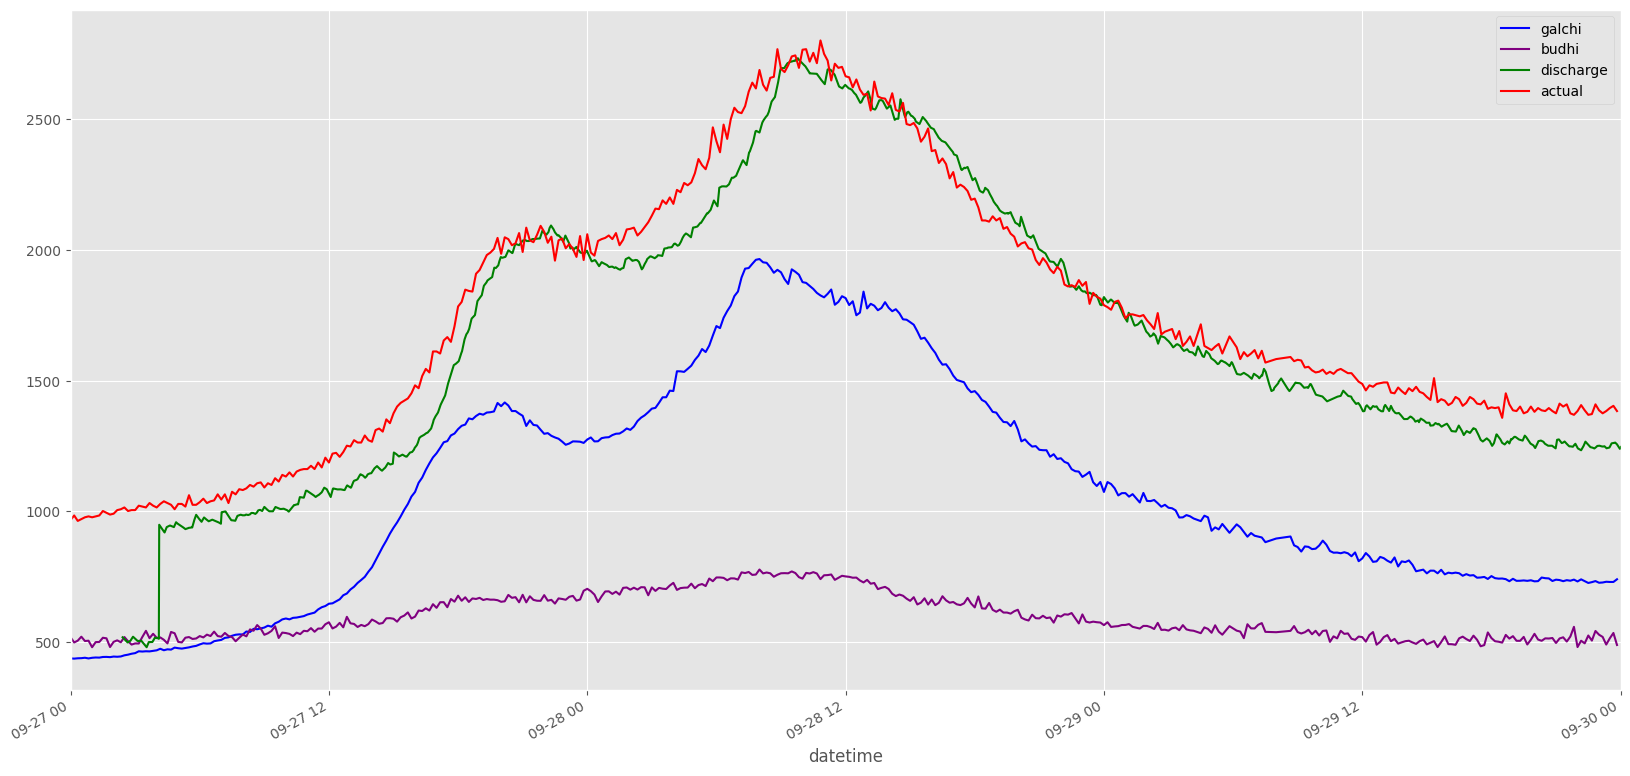

In [38]:
fig,ax=plt.subplots(figsize=(20,10))
galchi_df['discharge'].plot(color='blue',ax=ax,label='galchi')
budhi_df['discharge'].plot(color='purple',ax=ax,label='budhi')
computed_suirenitar_df.plot(color='green',ax=ax,label='computed')
suirenitar_df['discharge'].plot(color='red',ax=ax,label='actual')
ax.set_xlim(['2024-09-27', '2024-09-30'])
plt.legend()
plt.show()